In [1]:
!pip install yfinance

In [5]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

# Define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# List of stock tickers to download
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS']

# Download data using yfinance
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', progress=False)

# Reset index to bring Date into the columns
data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()

# Melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date', 'Ticker'], var_name='Attribute', value_name='Value')

# Pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
stock_data = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value', aggfunc='first')

# Reset index to turn multi-index into columns
stock_data = stock_data.reset_index()

print(stock_data.head())


Attribute       Date       Ticker    Adj Close        Close         High  \
0         2023-12-06  HDFCBANK.NS  1605.871216  1627.800049  1638.449951   
1         2023-12-06      INFY.NS  1449.532959  1474.300049  1477.000000   
2         2023-12-06  RELIANCE.NS  1222.225342  1230.550049  1236.474976   
3         2023-12-06       TCS.NS  3544.690186  3604.100098  3612.850098   
4         2023-12-07  HDFCBANK.NS  1608.485352  1630.449951  1634.000000   

Attribute          Low         Open      Volume  
0          1616.650024  1638.449951  19306530.0  
1          1451.050049  1456.750000   5269178.0  
2          1217.500000  1223.550049  16422442.0  
3          3525.149902  3532.600098   1896572.0  
4          1616.199951  1625.000000  10225193.0  


C:\Users\HP\AppData\Local\Temp\ipykernel_24324\1940134413.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()


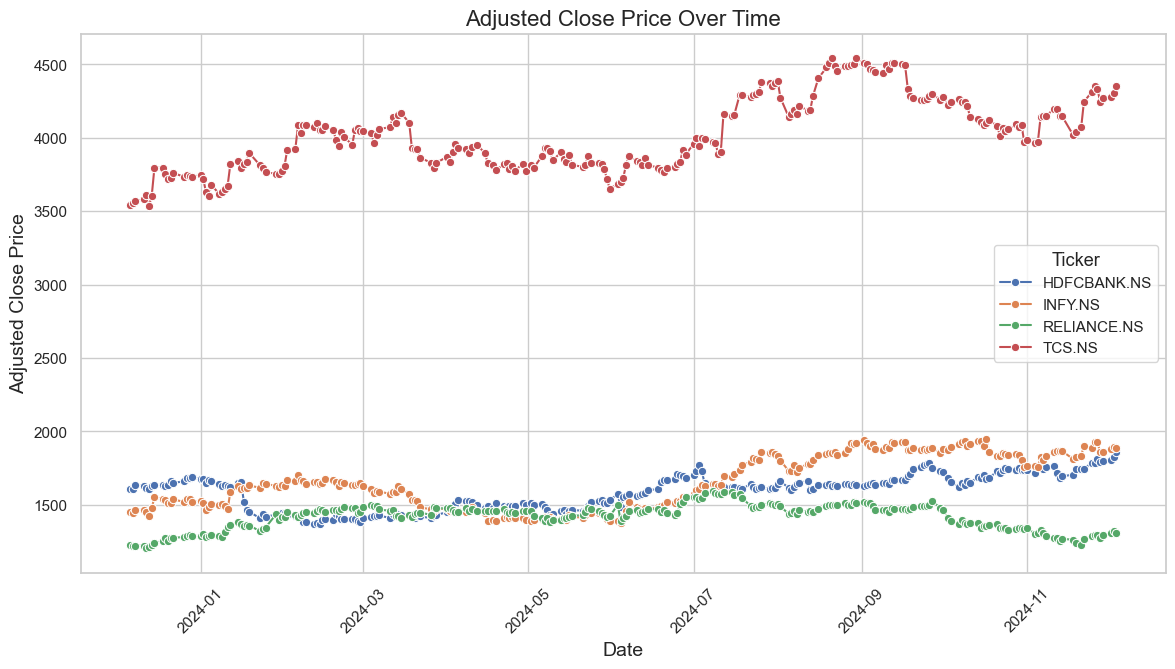

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data.set_index('Date', inplace=True)
stock_data.reset_index(inplace=True)
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

sns.lineplot(data=stock_data, x='Date', y='Adj Close', hue='Ticker', marker='o')

plt.title('Adjusted Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Adjusted Close Price', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

## Now, let’s compute the 50-day and 200-day moving averages and plot these along with the Adjusted Close price for each stock:

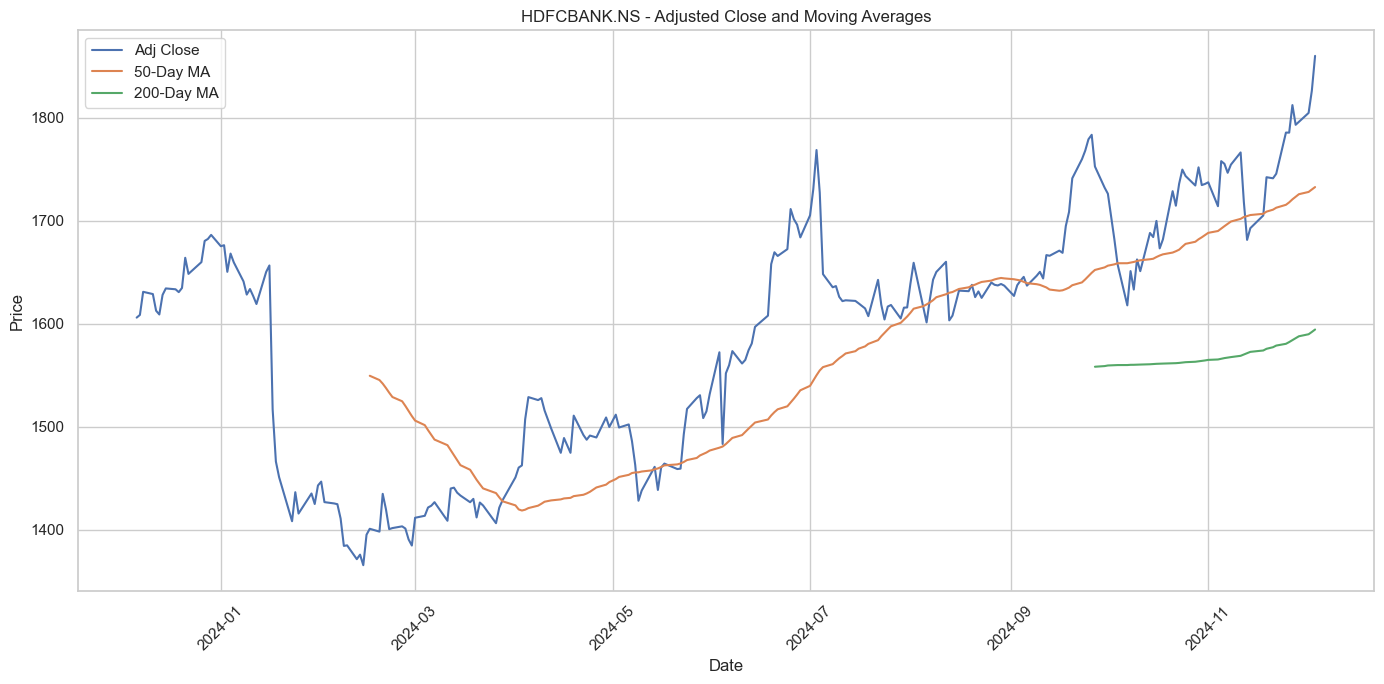

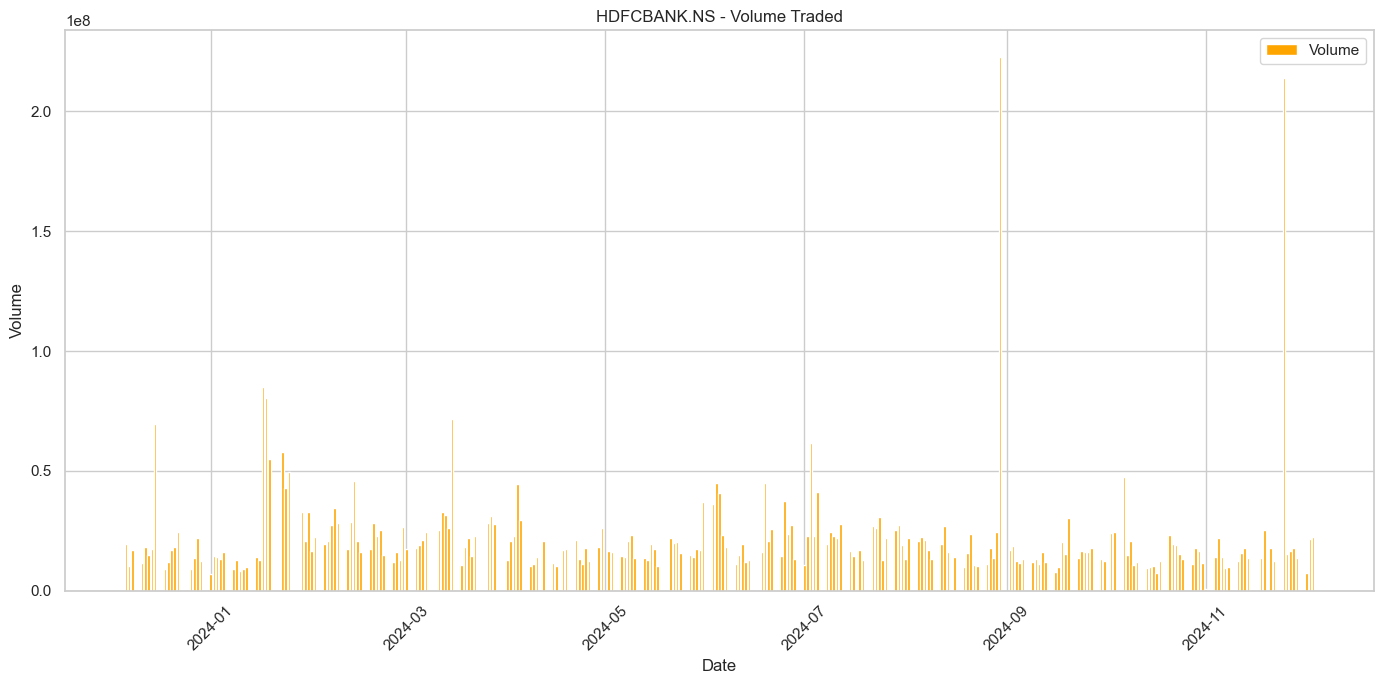

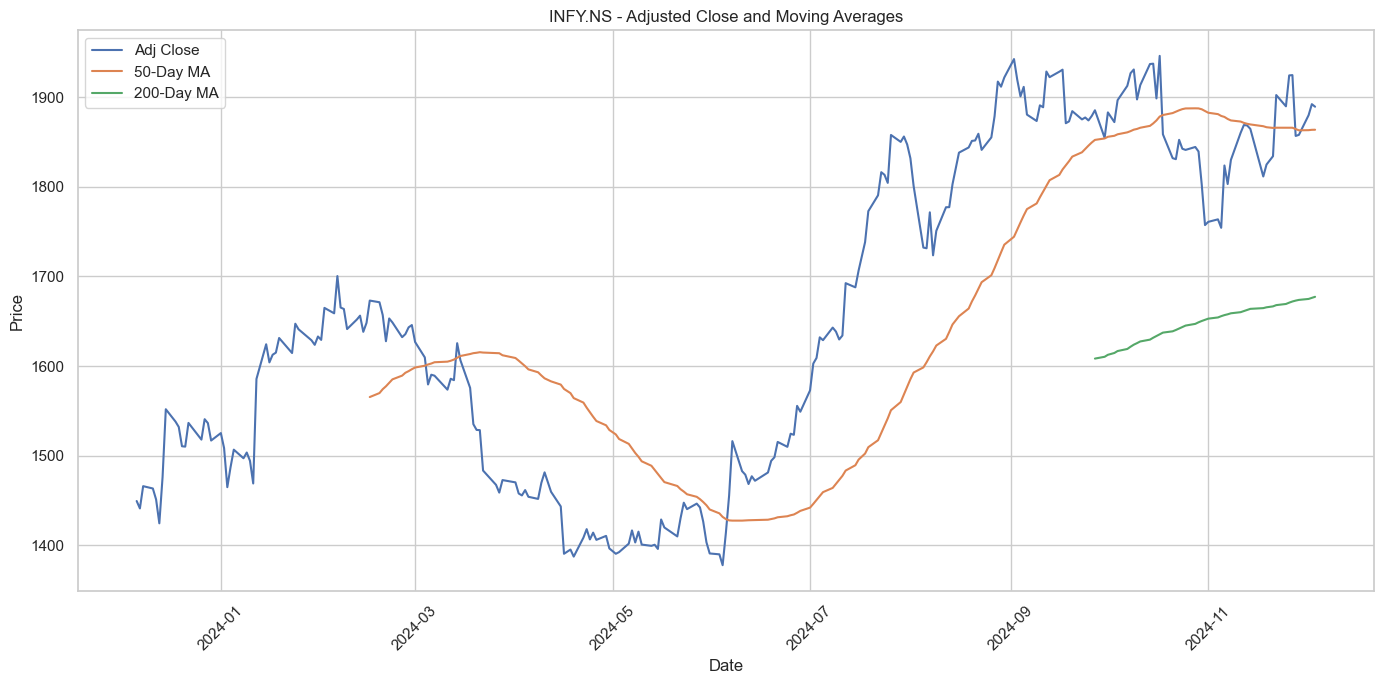

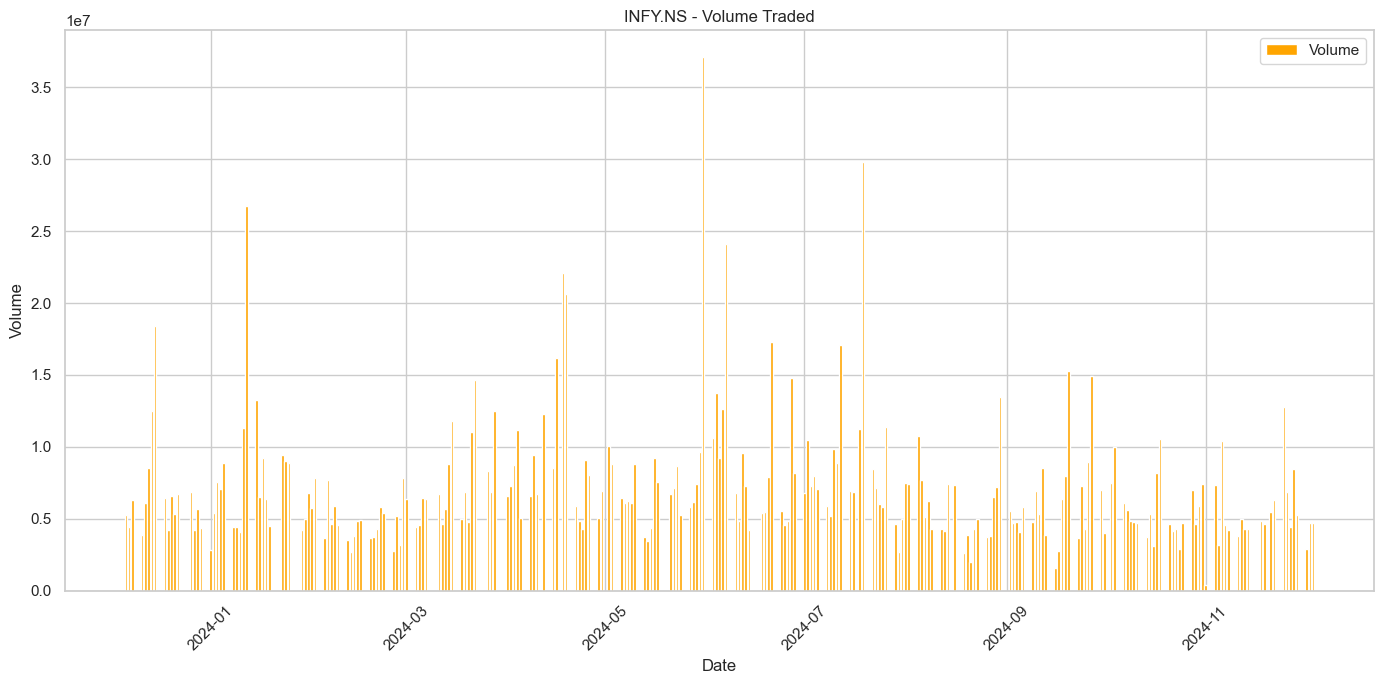

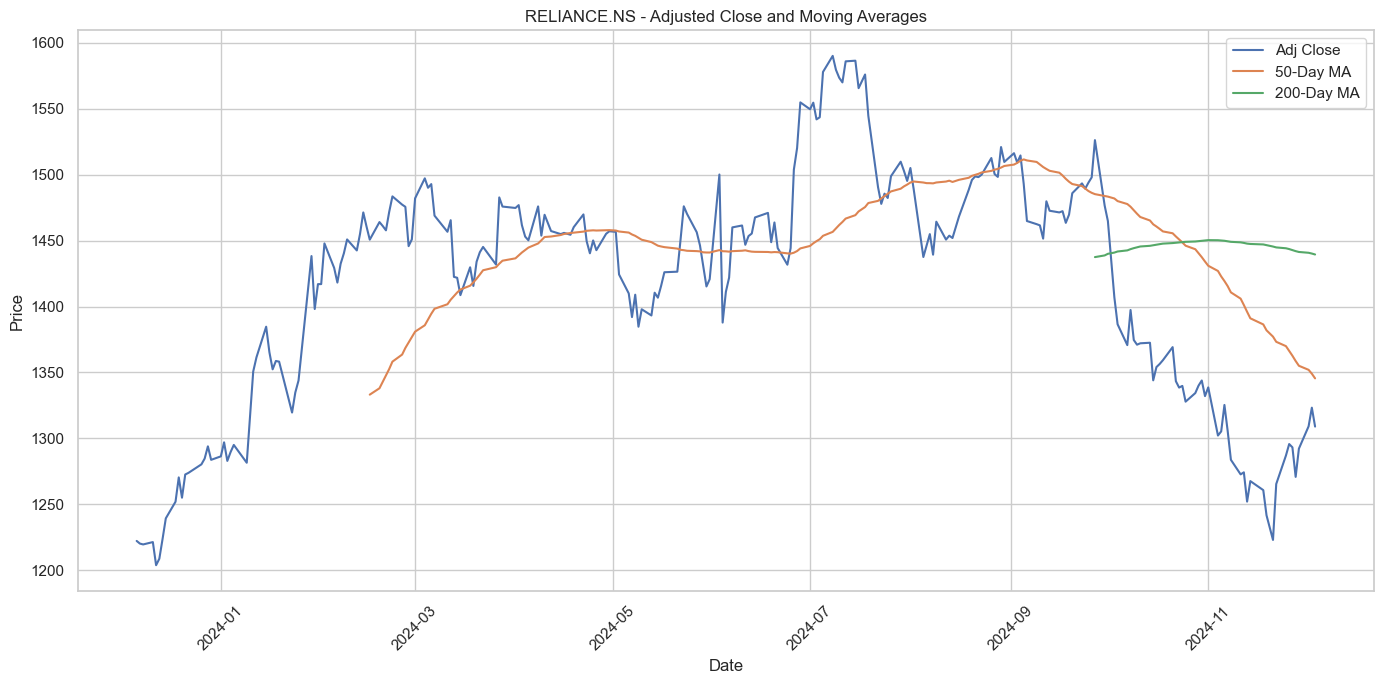

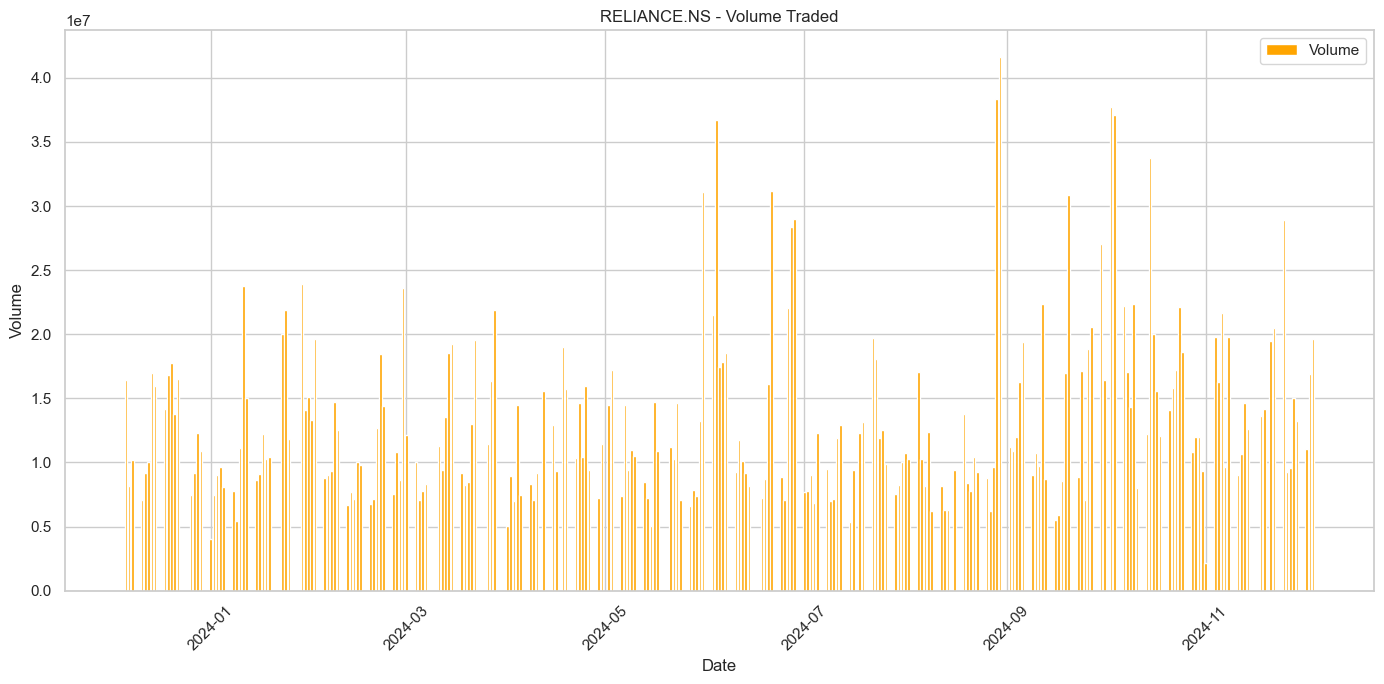

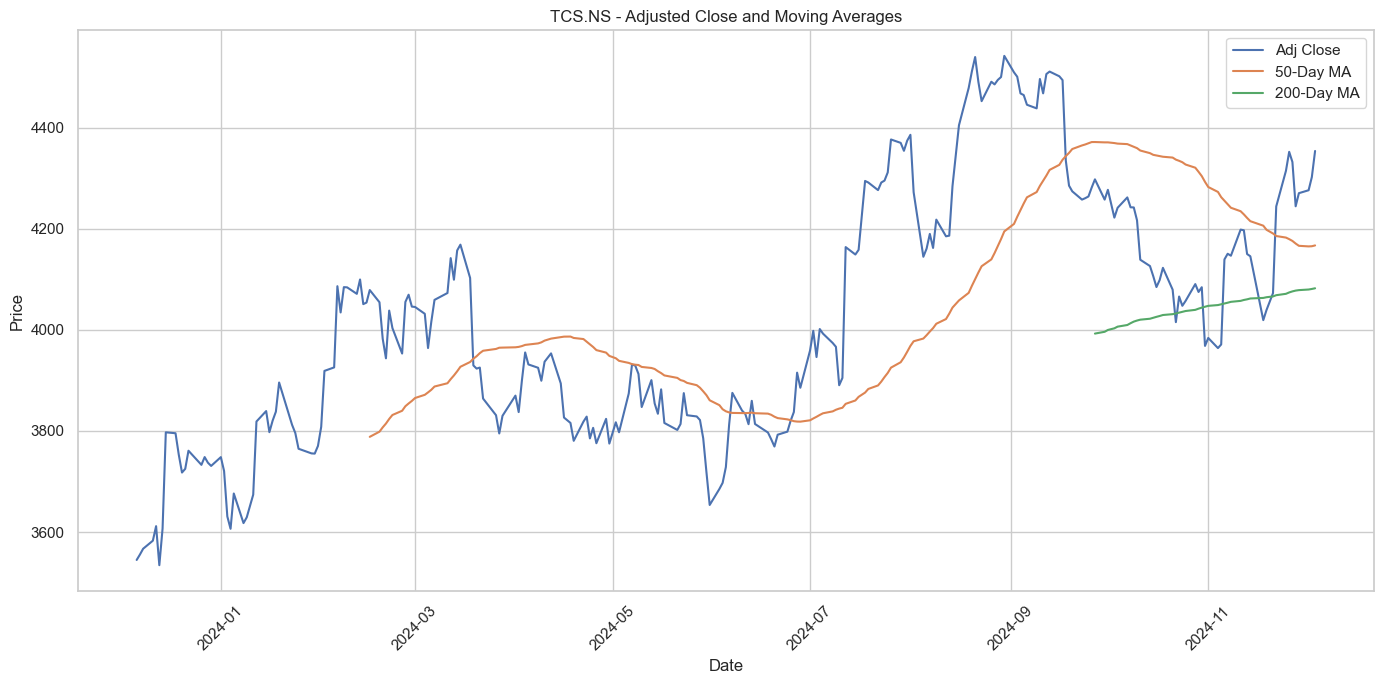

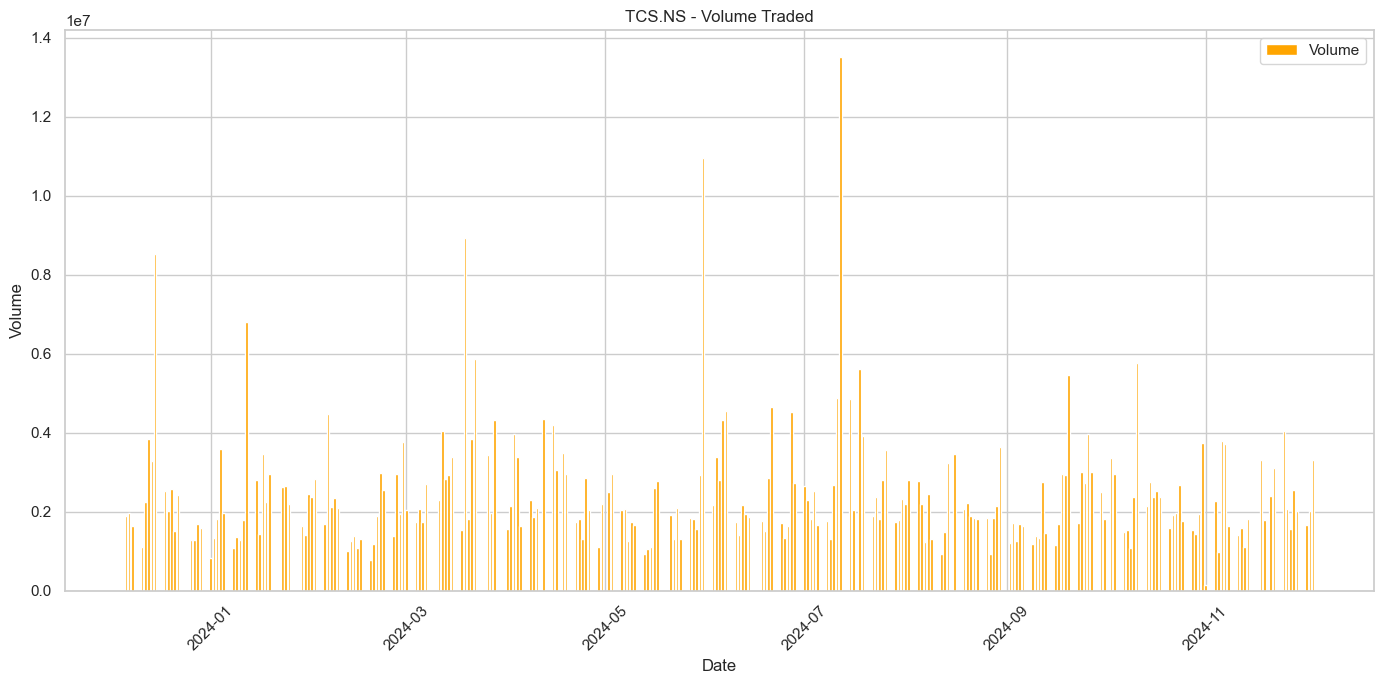

In [8]:
short_window = 50
long_window = 200

stock_data.set_index('Date', inplace=True)
unique_tickers = stock_data['Ticker'].unique()

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker].copy()
    ticker_data['50_MA'] = ticker_data['Adj Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label='Adj Close')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day MA')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day MA')
    plt.title(f'{ticker} - Adjusted Close and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Now, let’s have a look at the distribution of daily returns of these stocks:

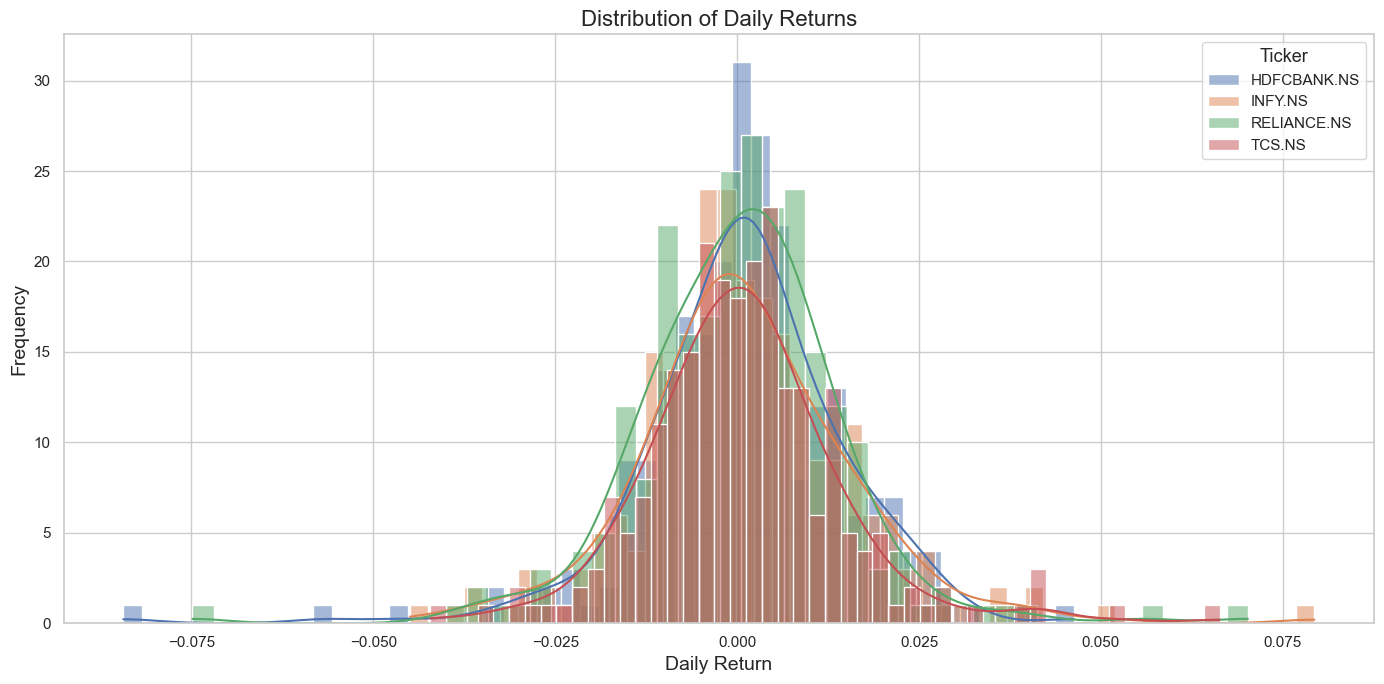

In [10]:
stock_data['Daily Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')

for ticker in unique_tickers:
    ticker_data = stock_data[stock_data['Ticker'] == ticker]
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, label=ticker, alpha=0.5)

plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Ticker', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

## The distributions are approximately normal, centred around zero, which indicates that most daily returns are close to the average return. However, there are tails on both sides, which reflect occasional significant gains or losses. INFY and RELIANCE appear to have slightly wider distributions, which suggests higher volatility compared to HDFCBANK and TCS.

## Now, let’s see if there’s any correlation between all these stocks:



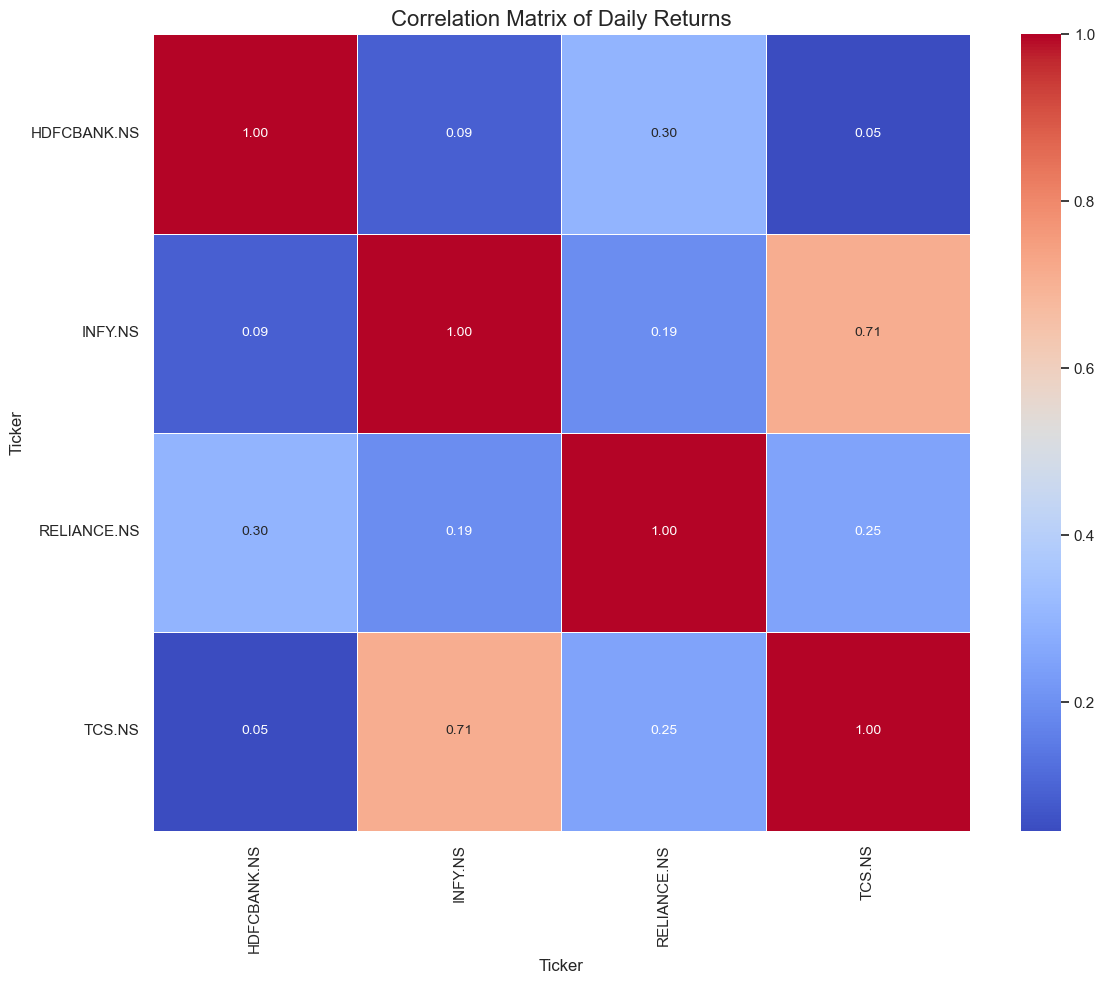

In [11]:
daily_returns = stock_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(12, 10))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Portfolio Optimization
Now, using Modern Portfolio Theory, we can construct an efficient portfolio by balancing risk and return. We will:

Calculate the expected returns and volatility for each stock.
Generate a series of random portfolios to identify the efficient frontier.
Optimize the portfolio to maximize the Sharpe ratio, which is a measure of risk-adjusted return.

# Let’s calculate the expected returns and volatility for each stock:

In [12]:
import numpy as np

expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

stock_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

stock_stats

,Expected Return,Volatility
Ticker,,
HDFCBANK.NS,0.177066,0.223897
INFY.NS,0.301854,0.238292
RELIANCE.NS,0.096807,0.228455
TCS.NS,0.235611,0.215935


# Next, we will:

Generate a large number of random portfolio weights.
Calculate the expected return and volatility for each portfolio.
Plot these portfolios to visualize the efficient frontier.

# Let’s generate the random portfolios and plot the efficient frontier:



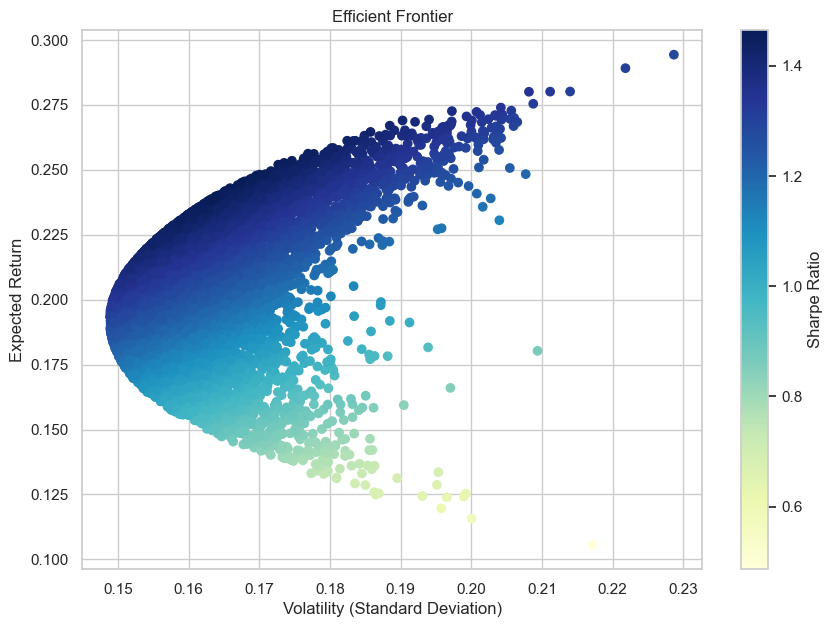

In [14]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

# Each dot represents a portfolio, with the colour indicating the Sharpe ratio, a measure of risk-adjusted return. Portfolios on the leftmost edge of the frontier (closer to the y-axis) offer the highest expected returns for a given level of volatility, which represent optimal portfolios. The gradient shows that portfolios with higher Sharpe ratios (darker blue) provide better risk-adjusted returns.

# Here’s how to identify the portfolio with the maximum Sharpe ratio:

In [16]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(0.24292128154530776, 0.16586244964217123, 1.4645948017129973)

# The portfolio with the maximum Sharpe ratio has the following characteristics:

* Expected Return: ~26.08%
* Volatility: ~15.54%
* Sharpe Ratio: ~1.68

# Next, let’s identify the weights of the stocks in the portfolio that yield the maximum Sharpe ratio:

In [17]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,HDFCBANK.NS,0.250219
1,INFY.NS,0.295627
2,RELIANCE.NS,0.394525
3,TCS.NS,0.059630


# Summary
So, this is how stock market portfolio optimization works. Stock market portfolio optimization involves analyzing price trends, calculating expected returns and volatilities, and determining the correlations between different stocks to achieve diversification.